# Notebook 02: Noise Injection and Artifact Simulation
## Benchmarking SAM & MedSAM Robustness under Noisy Abdominal CT Conditions

**Author:** Hoang Le Chau     
**Date:** January 2026

---

### Objective
Implement comprehensive noise injection pipeline to simulate realistic medical imaging artifacts:
1. Gaussian noise
2. Poisson noise
3. Salt-and-pepper noise
4. Motion blur
5. Intensity inhomogeneity (bias field)
6. Low-contrast degradation

Each noise type will be applied at multiple intensity levels (mild, moderate, severe).

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from pathlib import Path
from tqdm import tqdm
from scipy import ndimage
from skimage.util import random_noise
from skimage import exposure
import cv2
import warnings
warnings.filterwarnings('ignore')

plt.style.use('seaborn-v0_8-paper')
%matplotlib inline

print("Libraries imported successfully")

Libraries imported successfully


### 1. Mount Drive and Load Processed Data

In [2]:
from google.colab import drive
drive.mount('/content/drive')

BASE_PATH = Path('/content/drive/MyDrive/Colab Notebooks/AIMA/sam_noisy/')
OUTPUT_PATH = BASE_PATH / 'SAM_Robustness_Study'
PROCESSED_DATA_PATH = OUTPUT_PATH / 'processed_data'
NOISY_DATA_PATH = OUTPUT_PATH / 'noisy_data'
NOISY_DATA_PATH.mkdir(exist_ok=True)

print(f"Loading data from: {PROCESSED_DATA_PATH}")
print(f"Noisy data will be saved to: {NOISY_DATA_PATH}")

Mounted at /content/drive
Loading data from: /content/drive/MyDrive/Colab Notebooks/AIMA/sam_noisy/SAM_Robustness_Study/processed_data
Noisy data will be saved to: /content/drive/MyDrive/Colab Notebooks/AIMA/sam_noisy/SAM_Robustness_Study/noisy_data


In [3]:
def load_dataset(dataset_name):
    """
    Load processed dataset from Notebook 01.

    Args:
        dataset_name: Name of dataset (e.g., 'liver' or 'spleen')

    Returns:
        Dictionary with images, labels, and metadata
    """
    dataset_path = PROCESSED_DATA_PATH / dataset_name

    images = np.load(dataset_path / 'images.npy')
    labels = np.load(dataset_path / 'labels.npy')
    metadata = pd.read_csv(dataset_path / 'metadata.csv')

    return {
        'images': images,
        'labels': labels,
        'metadata': metadata
    }

liver_data = load_dataset('liver')
spleen_data = load_dataset('spleen')

print(f"\nLiver dataset: {liver_data['images'].shape}")
print(f"Spleen dataset: {spleen_data['images'].shape}")


Liver dataset: (50, 512, 512)
Spleen dataset: (50, 512, 512)


### 2. Noise Injection Functions

Implementation of six noise types with intensity control.

In [4]:
class NoiseInjector:
    """
    Class implementing various medical imaging noise and artifact types.
    Fixed for scikit-image 0.19+ compatibility.
    """

    def __init__(self, seed=42):
        """
        Initialize noise injector with random seed for reproducibility.

        Args:
            seed: Random seed
        """
        self.seed = seed
        np.random.seed(seed)

    def normalize_image(self, image):
        """
        Normalize image to [0, 1] range.
        """
        img_min = image.min()
        img_max = image.max()
        if img_max - img_min > 0:
            return (image - img_min) / (img_max - img_min)
        return image

    def denormalize_image(self, normalized_image, original_image):
        """
        Denormalize image back to original range.
        """
        img_min = original_image.min()
        img_max = original_image.max()
        return normalized_image * (img_max - img_min) + img_min

    def add_gaussian_noise(self, image, intensity='mild'):
        """
        Add Gaussian noise to image.

        Args:
            image: Input image
            intensity: 'mild', 'moderate', or 'severe'

        Returns:
            Noisy image
        """
        sigma_map = {'mild': 0.02, 'moderate': 0.05, 'severe': 0.10}
        sigma = sigma_map.get(intensity, 0.02)

        normalized = self.normalize_image(image)
        # FINAL FIX: Pass integer seed directly, not RandomState
        noisy = random_noise(normalized, mode='gaussian', var=sigma**2, rng=self.seed)
        return self.denormalize_image(noisy, image)

    def add_poisson_noise(self, image, intensity='mild'):
        """
        Add Poisson noise to image (simulates photon counting noise).

        Args:
            image: Input image
            intensity: 'mild', 'moderate', or 'severe'

        Returns:
            Noisy image
        """
        scale_map = {'mild': 10, 'moderate': 5, 'severe': 2}
        scale = scale_map.get(intensity, 10)

        normalized = self.normalize_image(image)
        scaled = normalized * scale
        noisy = np.random.poisson(scaled) / scale
        noisy = np.clip(noisy, 0, 1)
        return self.denormalize_image(noisy, image)

    def add_salt_pepper_noise(self, image, intensity='mild'):
        """
        Add salt-and-pepper noise to image.

        Args:
            image: Input image
            intensity: 'mild', 'moderate', or 'severe'

        Returns:
            Noisy image
        """
        amount_map = {'mild': 0.01, 'moderate': 0.03, 'severe': 0.07}
        amount = amount_map.get(intensity, 0.01)

        normalized = self.normalize_image(image)
        # FINAL FIX: Pass integer seed directly
        noisy = random_noise(normalized, mode='s&p', amount=amount, rng=self.seed)
        return self.denormalize_image(noisy, image)

    def add_motion_blur(self, image, intensity='mild'):
        """
        Add motion blur to image.

        Args:
            image: Input image
            intensity: 'mild', 'moderate', or 'severe'

        Returns:
            Blurred image
        """
        kernel_size_map = {'mild': 5, 'moderate': 9, 'severe': 15}
        kernel_size = kernel_size_map.get(intensity, 5)

        kernel = np.zeros((kernel_size, kernel_size))
        kernel[int((kernel_size-1)/2), :] = np.ones(kernel_size)
        kernel = kernel / kernel_size

        angle = np.random.uniform(0, 180)
        center = (kernel_size // 2, kernel_size // 2)
        M = cv2.getRotationMatrix2D(center, angle, 1.0)
        kernel = cv2.warpAffine(kernel, M, (kernel_size, kernel_size))

        blurred = cv2.filter2D(image.astype(np.float32), -1, kernel)
        return blurred

    def add_intensity_inhomogeneity(self, image, intensity='mild'):
        """
        Add bias field (intensity inhomogeneity) to image.

        Args:
            image: Input image
            intensity: 'mild', 'moderate', or 'severe'

        Returns:
            Image with bias field
        """
        strength_map = {'mild': 0.15, 'moderate': 0.30, 'severe': 0.50}
        strength = strength_map.get(intensity, 0.15)

        h, w = image.shape

        x = np.linspace(-1, 1, w)
        y = np.linspace(-1, 1, h)
        X, Y = np.meshgrid(x, y)

        cx, cy = np.random.uniform(-0.5, 0.5, 2)
        bias_field = 1 + strength * (X - cx) * (Y - cy)
        bias_field = ndimage.gaussian_filter(bias_field, sigma=min(h, w) / 8)

        corrected = image * bias_field
        return corrected

    def add_low_contrast(self, image, intensity='mild'):
        """
        Reduce image contrast.

        Args:
            image: Input image
            intensity: 'mild', 'moderate', or 'severe'

        Returns:
            Low contrast image
        """
        factor_map = {'mild': 0.7, 'moderate': 0.5, 'severe': 0.3}
        factor = factor_map.get(intensity, 0.7)

        normalized = self.normalize_image(image)
        mean_val = normalized.mean()
        low_contrast = mean_val + factor * (normalized - mean_val)
        return self.denormalize_image(low_contrast, image)

print("NoiseInjector class defined successfully")

NoiseInjector class defined successfully


### 3. Visualize Noise Effects on Sample Image

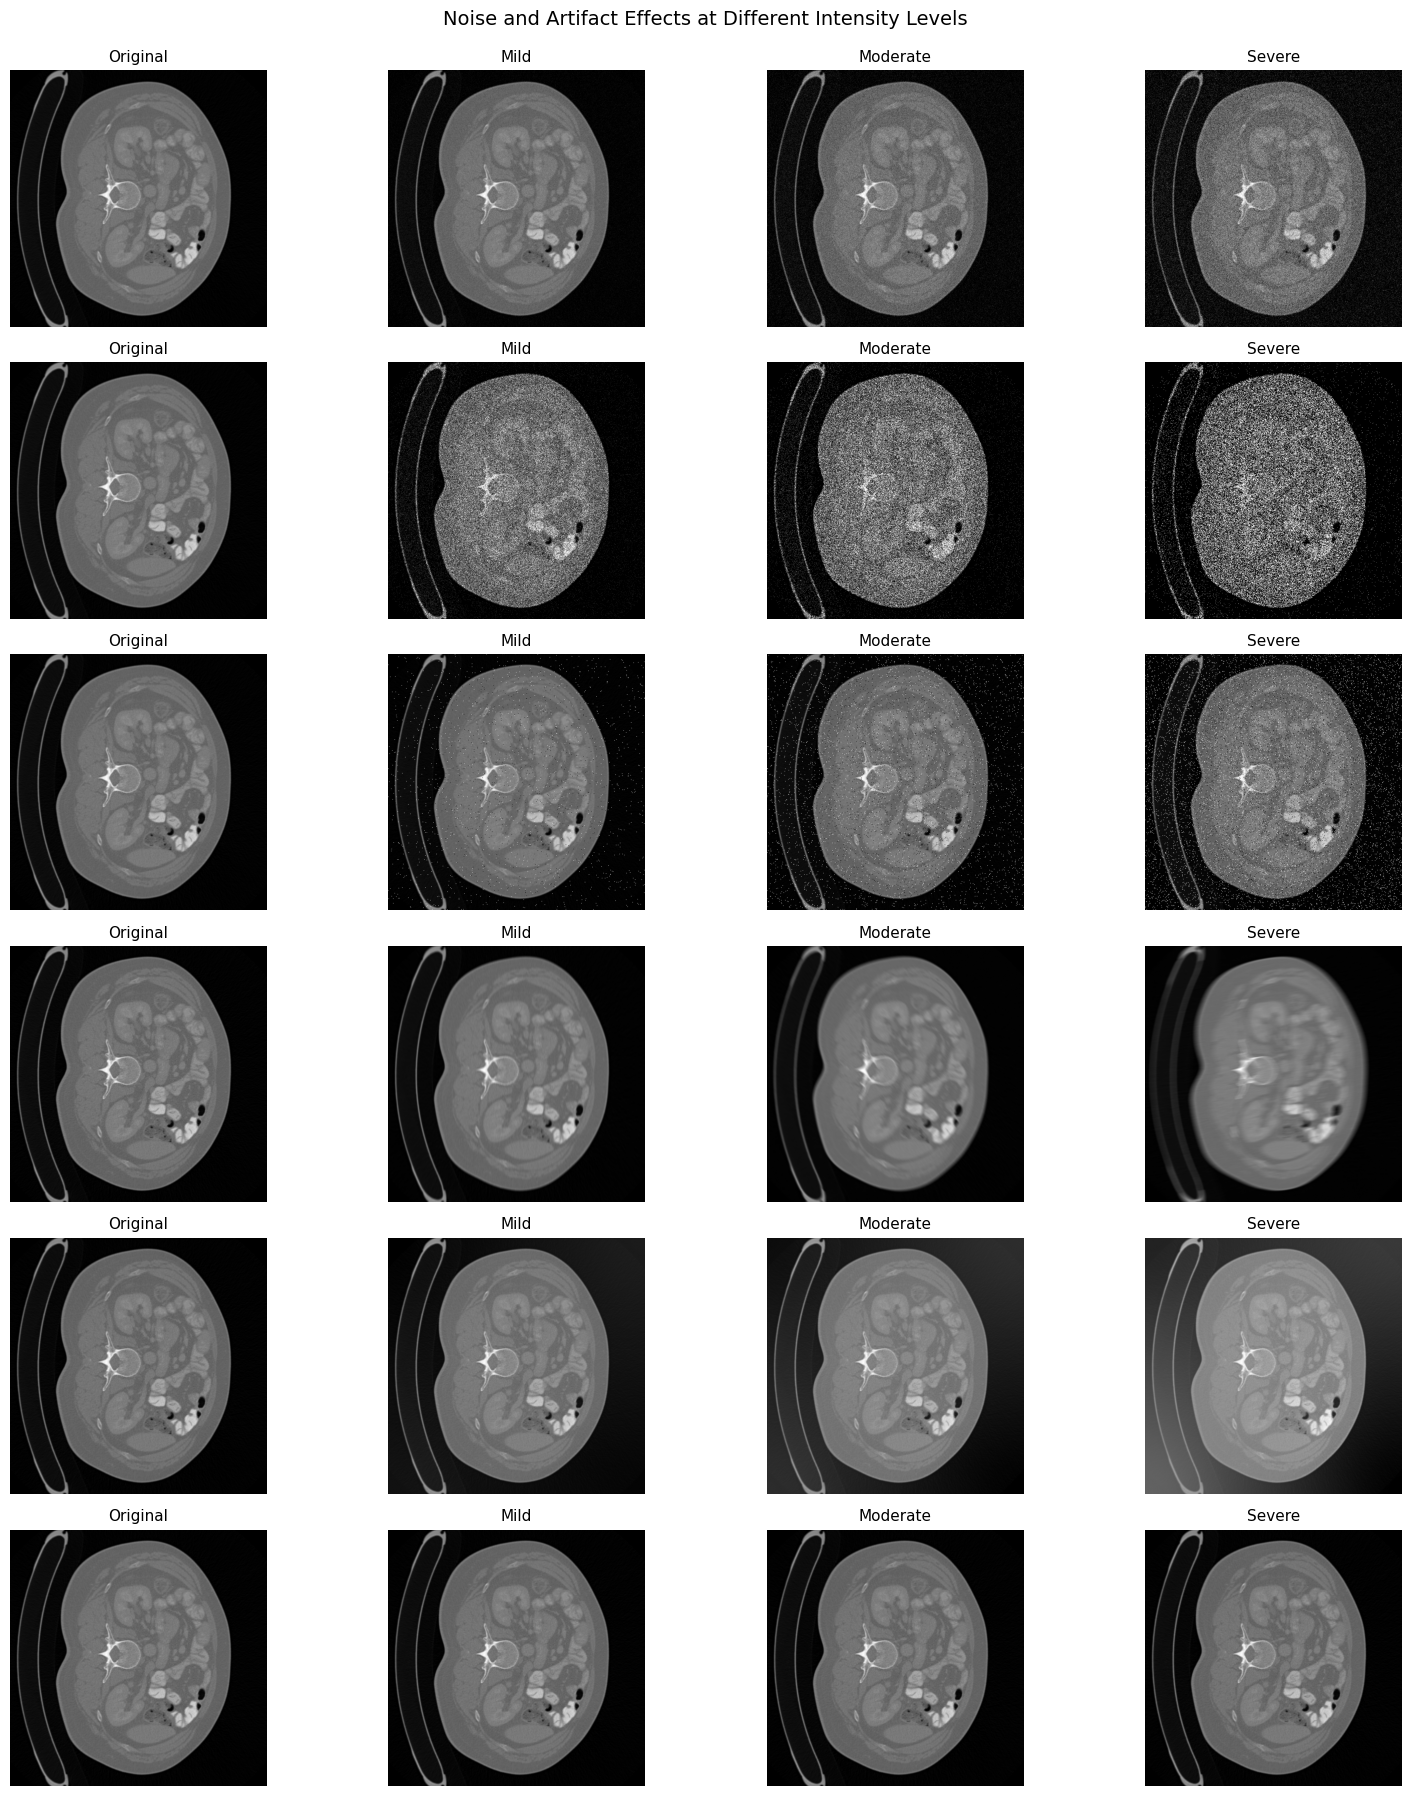

In [5]:
def visualize_noise_effects(image, noise_injector):
    """
    Visualize all noise types at different intensity levels on a single image.

    Args:
        image: Sample image
        noise_injector: NoiseInjector instance
    """
    noise_types = [
        ('Gaussian', noise_injector.add_gaussian_noise),
        ('Poisson', noise_injector.add_poisson_noise),
        ('Salt & Pepper', noise_injector.add_salt_pepper_noise),
        ('Motion Blur', noise_injector.add_motion_blur),
        ('Intensity Inhomogeneity', noise_injector.add_intensity_inhomogeneity),
        ('Low Contrast', noise_injector.add_low_contrast)
    ]

    intensities = ['mild', 'moderate', 'severe']

    fig, axes = plt.subplots(len(noise_types), len(intensities) + 1,
                            figsize=(16, 3*len(noise_types)))

    for i, (noise_name, noise_func) in enumerate(noise_types):
        axes[i, 0].imshow(image, cmap='gray')
        axes[i, 0].set_title('Original', fontsize=11)
        axes[i, 0].axis('off')
        axes[i, 0].set_ylabel(noise_name, fontsize=12, rotation=0,
                             ha='right', va='center', labelpad=20)

        for j, intensity in enumerate(intensities):
            noisy_image = noise_func(image.copy(), intensity=intensity)
            axes[i, j+1].imshow(noisy_image, cmap='gray')
            axes[i, j+1].set_title(f'{intensity.capitalize()}', fontsize=11)
            axes[i, j+1].axis('off')

    plt.suptitle('Noise and Artifact Effects at Different Intensity Levels',
                fontsize=14, y=0.995)
    plt.tight_layout()
    plt.savefig(OUTPUT_PATH / 'noise_effects_visualization.png', dpi=150, bbox_inches='tight')
    plt.show()

noise_injector = NoiseInjector(seed=42)
sample_image = liver_data['images'][10]

visualize_noise_effects(sample_image, noise_injector)

### 4. Generate Complete Noisy Dataset

In [6]:
def generate_noisy_dataset(images, labels, metadata, noise_injector, dataset_name):
    """
    Generate complete noisy dataset with all noise types and intensity levels.

    Args:
        images: Array of clean images
        labels: Array of corresponding labels
        metadata: DataFrame with metadata
        noise_injector: NoiseInjector instance
        dataset_name: Name for saving

    Returns:
        Dictionary containing noisy images organized by noise type and intensity
    """
    noise_functions = {
        'gaussian': noise_injector.add_gaussian_noise,
        'poisson': noise_injector.add_poisson_noise,
        'salt_pepper': noise_injector.add_salt_pepper_noise,
        'motion_blur': noise_injector.add_motion_blur,
        'intensity_inhomogeneity': noise_injector.add_intensity_inhomogeneity,
        'low_contrast': noise_injector.add_low_contrast
    }

    intensities = ['mild', 'moderate', 'severe']

    noisy_data = {
        'clean': {
            'images': images,
            'labels': labels,
            'metadata': metadata
        }
    }

    print(f"\nGenerating noisy dataset for {dataset_name}...")
    print(f"Total images: {len(images)}")
    print(f"Noise types: {len(noise_functions)}")
    print(f"Intensity levels: {len(intensities)}")
    print(f"Total variants to generate: {len(images) * len(noise_functions) * len(intensities)}\n")

    for noise_name, noise_func in noise_functions.items():
        for intensity in intensities:
            key = f"{noise_name}_{intensity}"

            noisy_images = []
            for img in tqdm(images, desc=f"{noise_name} - {intensity}"):
                noisy_img = noise_func(img.copy(), intensity=intensity)
                noisy_images.append(noisy_img)

            noisy_data[key] = {
                'images': np.array(noisy_images),
                'labels': labels.copy(),
                'metadata': metadata.copy(),
                'noise_type': noise_name,
                'intensity': intensity
            }

    return noisy_data

print("Generating noisy dataset for Liver...")
liver_noisy = generate_noisy_dataset(
    liver_data['images'],
    liver_data['labels'],
    liver_data['metadata'],
    noise_injector,
    'Liver'
)

print("\nGenerating noisy dataset for Spleen...")
spleen_noisy = generate_noisy_dataset(
    spleen_data['images'],
    spleen_data['labels'],
    spleen_data['metadata'],
    noise_injector,
    'Spleen'
)

print("\nNoisy dataset generation complete!")

Generating noisy dataset for Liver...

Generating noisy dataset for Liver...
Total images: 50
Noise types: 6
Intensity levels: 3
Total variants to generate: 900



low_contrast - severe: 100%|██████████| 50/50 [00:00<00:00, 649.33it/s]



Generating noisy dataset for Spleen...

Generating noisy dataset for Spleen...
Total images: 50
Noise types: 6
Intensity levels: 3
Total variants to generate: 900



low_contrast - severe: 100%|██████████| 50/50 [00:00<00:00, 764.13it/s]



Noisy dataset generation complete!


### 5. Save Noisy Datasets

In [7]:
def save_noisy_dataset(noisy_data, dataset_name, output_path):
    """
    Save noisy dataset to disk with organized structure.

    Args:
        noisy_data: Dictionary containing all noisy variants
        dataset_name: Name of dataset
        output_path: Base path for saving
    """
    dataset_output = output_path / dataset_name.lower()
    dataset_output.mkdir(exist_ok=True)

    print(f"\nSaving {dataset_name} noisy dataset...")

    for key, data in tqdm(noisy_data.items(), desc="Saving variants"):
        variant_path = dataset_output / key
        variant_path.mkdir(exist_ok=True)

        np.save(variant_path / 'images.npy', data['images'])
        np.save(variant_path / 'labels.npy', data['labels'])
        data['metadata'].to_csv(variant_path / 'metadata.csv', index=False)

        if key != 'clean':
            info = {
                'noise_type': data['noise_type'],
                'intensity': data['intensity'],
                'num_images': len(data['images'])
            }
            with open(variant_path / 'info.txt', 'w') as f:
                for k, v in info.items():
                    f.write(f"{k}: {v}\n")

    summary_info = {
        'dataset_name': dataset_name,
        'total_variants': len(noisy_data) - 1,
        'images_per_variant': len(noisy_data['clean']['images']),
        'noise_types': list(set([v['noise_type'] for k, v in noisy_data.items() if k != 'clean'])),
        'intensities': list(set([v['intensity'] for k, v in noisy_data.items() if k != 'clean']))
    }

    with open(dataset_output / 'dataset_info.txt', 'w') as f:
        for k, v in summary_info.items():
            f.write(f"{k}: {v}\n")

    print(f"Saved to: {dataset_output}")
    print(f"Total variants saved: {len(noisy_data)}")

save_noisy_dataset(liver_noisy, 'Liver', NOISY_DATA_PATH)
save_noisy_dataset(spleen_noisy, 'Spleen', NOISY_DATA_PATH)


Saving Liver noisy dataset...


Saving variants: 100%|██████████| 19/19 [02:26<00:00,  7.69s/it]


Saved to: /content/drive/MyDrive/Colab Notebooks/AIMA/sam_noisy/SAM_Robustness_Study/noisy_data/liver
Total variants saved: 19

Saving Spleen noisy dataset...


Saving variants: 100%|██████████| 19/19 [02:19<00:00,  7.34s/it]


Saved to: /content/drive/MyDrive/Colab Notebooks/AIMA/sam_noisy/SAM_Robustness_Study/noisy_data/spleen
Total variants saved: 19


### 6. Create Comparison Visualization Grid

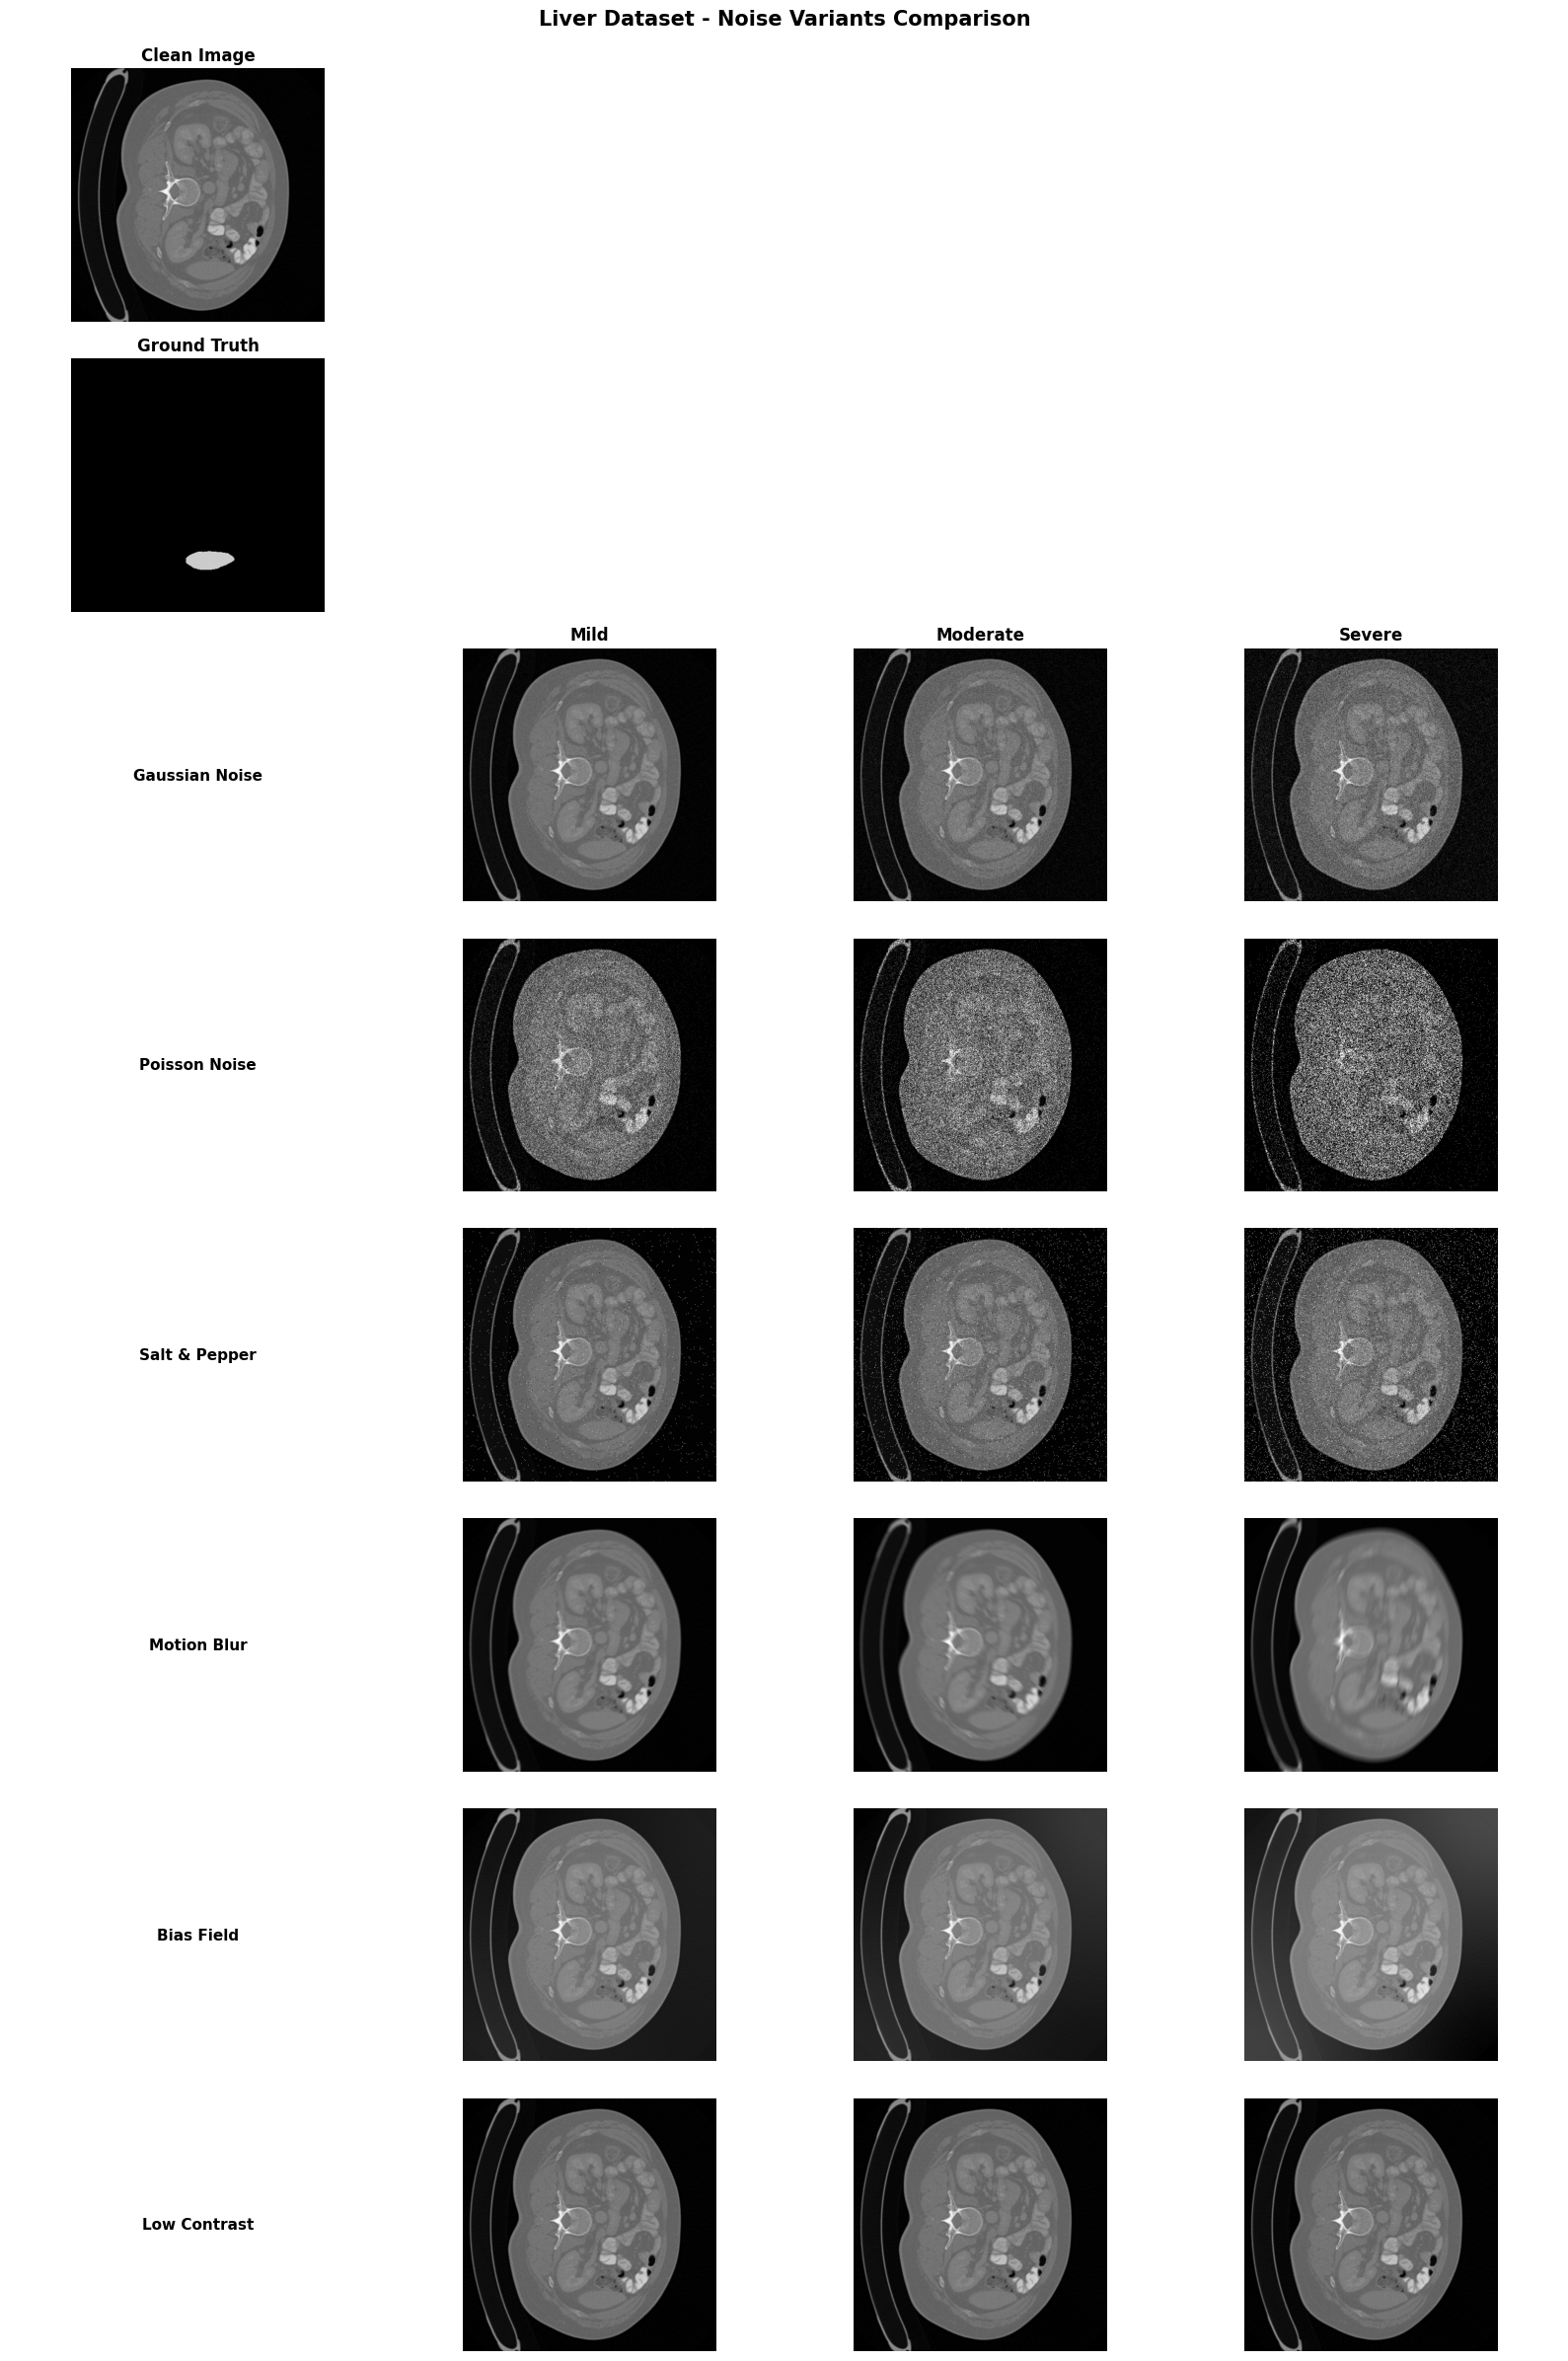

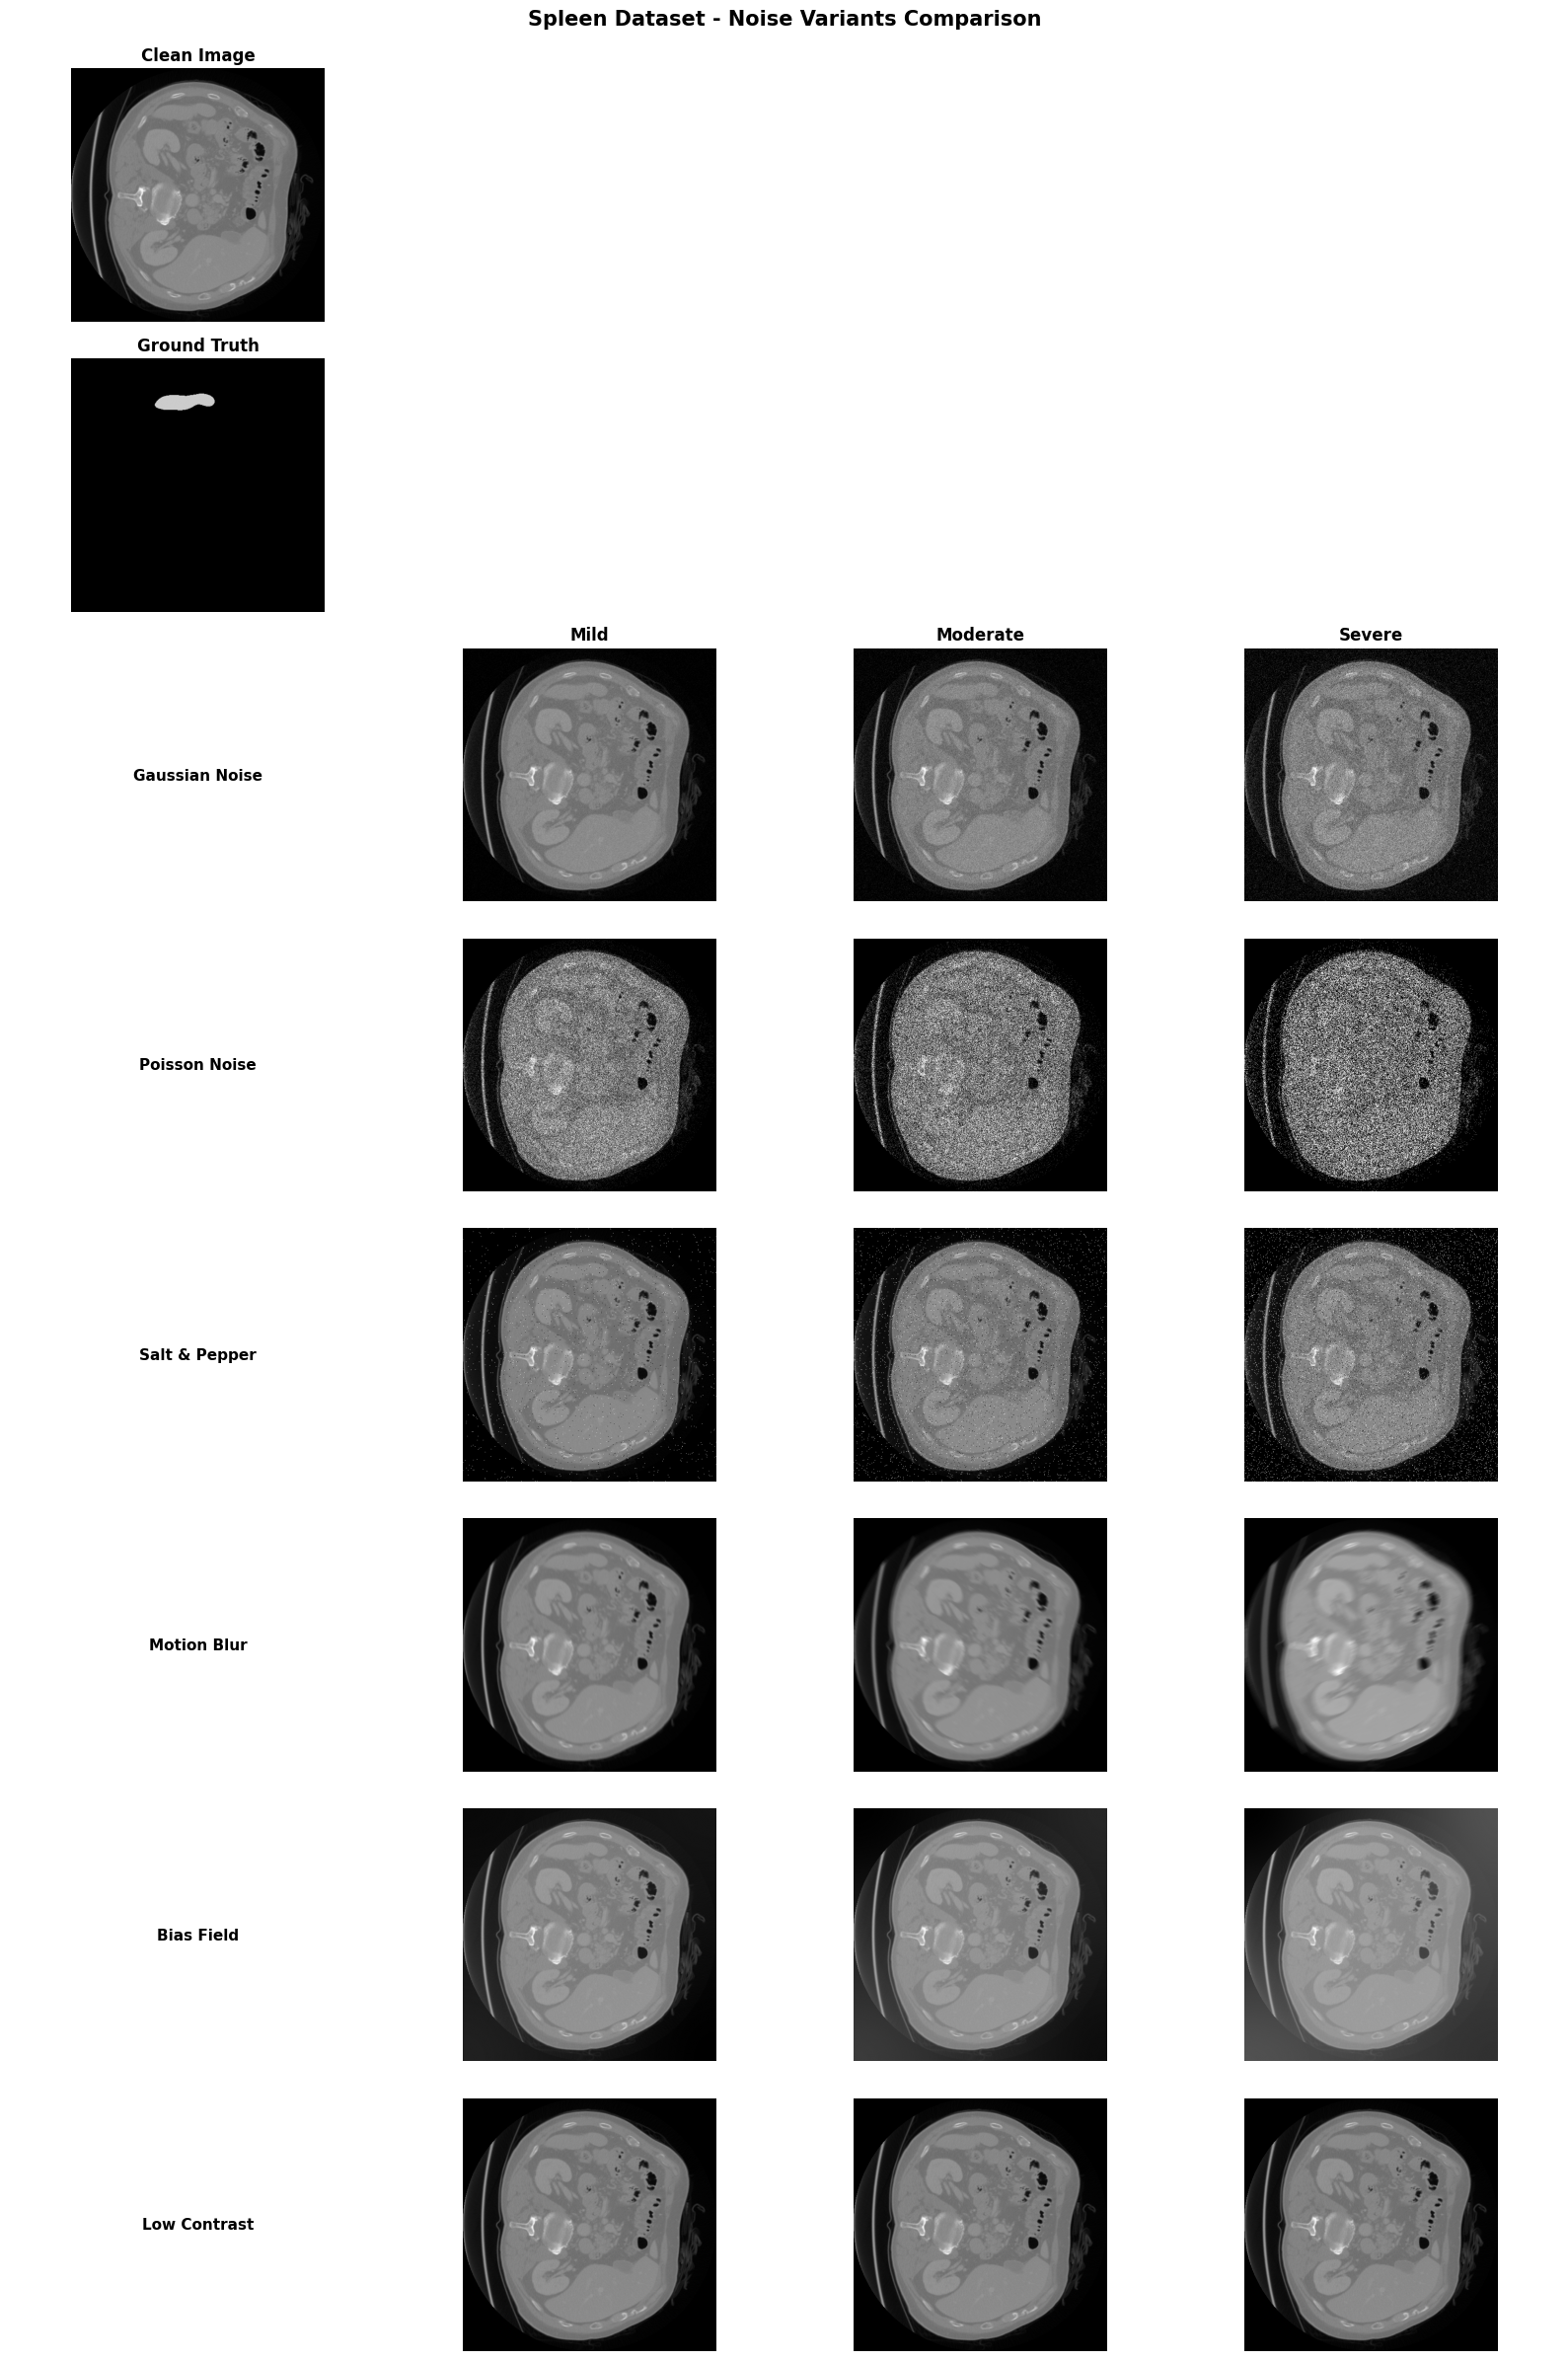

In [9]:
def create_noise_comparison_grid(noisy_data, sample_idx=0, dataset_name=''):
    """
    Create comprehensive visualization grid showing all noise variants.

    Args:
        noisy_data: Dictionary with all noise variants
        sample_idx: Index of sample to visualize
        dataset_name: Name for title
    """
    noise_types = ['gaussian', 'poisson', 'salt_pepper', 'motion_blur',
                   'intensity_inhomogeneity', 'low_contrast']
    intensities = ['mild', 'moderate', 'severe']

    noise_type_labels = {
        'gaussian': 'Gaussian Noise',
        'poisson': 'Poisson Noise',
        'salt_pepper': 'Salt & Pepper',
        'motion_blur': 'Motion Blur',
        'intensity_inhomogeneity': 'Bias Field',
        'low_contrast': 'Low Contrast'
    }

    fig, axes = plt.subplots(len(noise_types) + 2, len(intensities) + 1,
                            figsize=(16, 3*(len(noise_types)+2)))

    clean_img = noisy_data['clean']['images'][sample_idx]
    clean_lbl = noisy_data['clean']['labels'][sample_idx]

    axes[0, 0].imshow(clean_img, cmap='gray')
    axes[0, 0].set_title('Clean Image', fontsize=12, fontweight='bold')
    axes[0, 0].axis('off')

    for j in range(1, len(intensities) + 1):
        axes[0, j].axis('off')

    axes[1, 0].imshow(clean_lbl, cmap='nipy_spectral')
    axes[1, 0].set_title('Ground Truth', fontsize=12, fontweight='bold')
    axes[1, 0].axis('off')

    for j in range(1, len(intensities) + 1):
        axes[1, j].axis('off')

    for i, noise_type in enumerate(noise_types):
        axes[i+2, 0].text(0.5, 0.5, noise_type_labels[noise_type],
                         ha='center', va='center', fontsize=11, fontweight='bold',
                         transform=axes[i+2, 0].transAxes)
        axes[i+2, 0].axis('off')

        for j, intensity in enumerate(intensities):
            key = f"{noise_type}_{intensity}"
            noisy_img = noisy_data[key]['images'][sample_idx]

            axes[i+2, j+1].imshow(noisy_img, cmap='gray')
            if i == 0:
                axes[i+2, j+1].set_title(intensity.capitalize(), fontsize=12, fontweight='bold')
            axes[i+2, j+1].axis('off')

    plt.suptitle(f'{dataset_name} Dataset - Noise Variants Comparison',
                fontsize=15, fontweight='bold', y=0.995)
    plt.tight_layout()
    plt.savefig(OUTPUT_PATH / f'{dataset_name.lower()}_noise_comparison.png',
               dpi=150, bbox_inches='tight')
    plt.show()


create_noise_comparison_grid(liver_noisy, sample_idx=10, dataset_name='Liver')
create_noise_comparison_grid(spleen_noisy, sample_idx=10, dataset_name='Spleen')

### 7. Summary and Statistics

In [10]:
print("\n" + "="*70)
print("NOISE INJECTION SUMMARY")
print("="*70)

summary_data = []
for dataset_name, noisy_data in [('Liver', liver_noisy), ('Spleen', spleen_noisy)]:
    num_variants = len(noisy_data) - 1
    num_images = len(noisy_data['clean']['images'])
    total_images = num_variants * num_images

    summary_data.append({
        'Dataset': dataset_name,
        'Clean Images': num_images,
        'Noise Variants': num_variants,
        'Total Noisy Images': total_images,
        'Total (incl. clean)': total_images + num_images
    })

summary_df = pd.DataFrame(summary_data)
print(summary_df.to_string(index=False))
print("="*70)

print("\nNoise Types Applied:")
noise_types = ['Gaussian', 'Poisson', 'Salt & Pepper', 'Motion Blur',
               'Intensity Inhomogeneity', 'Low Contrast']
for nt in noise_types:
    print(f"  - {nt}")

print("\nIntensity Levels:")
for intensity in ['Mild', 'Moderate', 'Severe']:
    print(f"  - {intensity}")

summary_df.to_csv(OUTPUT_PATH / 'noise_injection_summary.csv', index=False)
print(f"\nSummary saved to {OUTPUT_PATH / 'noise_injection_summary.csv'}")


NOISE INJECTION SUMMARY
Dataset  Clean Images  Noise Variants  Total Noisy Images  Total (incl. clean)
  Liver            50              18                 900                  950
 Spleen            50              18                 900                  950

Noise Types Applied:
  - Gaussian
  - Poisson
  - Salt & Pepper
  - Motion Blur
  - Intensity Inhomogeneity
  - Low Contrast

Intensity Levels:
  - Mild
  - Moderate
  - Severe

Summary saved to /content/drive/MyDrive/Colab Notebooks/AIMA/sam_noisy/SAM_Robustness_Study/noise_injection_summary.csv
